In [9]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import random
import ipywidgets as widgets
from IPython.display import display

In [10]:

# Load the DataFrame from the CSV file
df = pd.read_csv('grad_cam_RVL_dataset.csv')

In [11]:
# Load CNN model
model = models.efficientnet_b0()
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 16)
model.load_state_dict(torch.load('model_CNN.pth'))
model.eval()

# Preprocess the image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])
    image = Image.open(image_path)
    image = preprocess(image).unsqueeze(0)
    return image

# Apply Grad CAM
def grad_cam(model, image_tensor, target_layer_name):
    gradients = []

    def save_gradient(grad):
        gradients.append(grad)

    target_layer = dict([*model.named_modules()])[target_layer_name]
    activations = []

    def save_activation(module, input, output):
        activations.append(output)
        output.register_hook(save_gradient)

    handle = target_layer.register_forward_hook(save_activation)

    # Move image tensor to the same device as the model
    image_tensor = image_tensor.to(next(model.parameters()).device)

    # Forward pass
    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()
    
    # Backward pass
    model.zero_grad()
    output[:, pred_class].backward()

    handle.remove()  # Remove the forward hook

    gradients = gradients[0].cpu().data.numpy()
    activations = activations[0].cpu().data.numpy()

    return gradients, activations, pred_class

def generate_heatmap(gradients, activations):
    weights = np.mean(gradients, axis=(2, 3))
    cam = np.zeros(activations.shape[2:], dtype=np.float32)

    for i, w in enumerate(weights[0]):
        cam += w * activations[0, i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = cam - cam.min()
    cam = cam / cam.max()
    return cam

def superimpose_heatmap(image_tensor, heatmap):
    image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min()) 
    image = np.uint8(255 * image)
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_PLASMA)
    superimposed_img = heatmap * 0.01 + image
    return superimposed_img


# Extract layers
def get_layers(model):
    layers = []
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            layers.append(name)
    return layers

Dropdown(description='Select Image:', options=('0000000171.tif', '0000000327.tif', '0000000870.tif', '00000021…

Dropdown(description='Select Layer:', options=('features.0.0', 'features.1.0.block.0.0', 'features.1.0.block.1…

Predicted class: 10
True class: 10


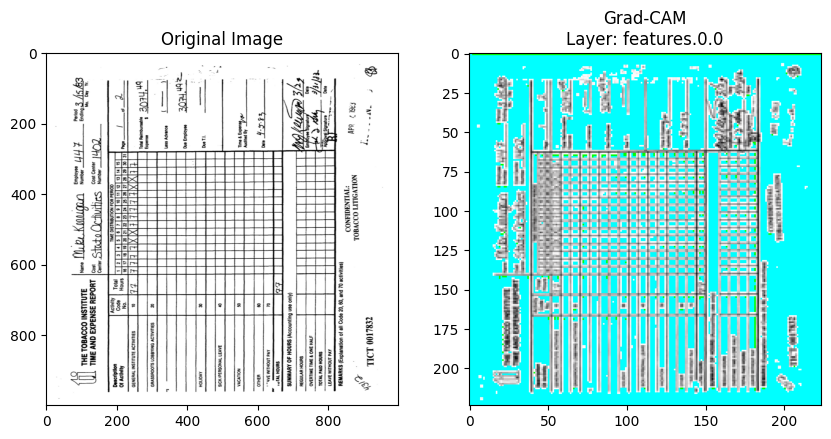

Predicted class: 10
True class: 10


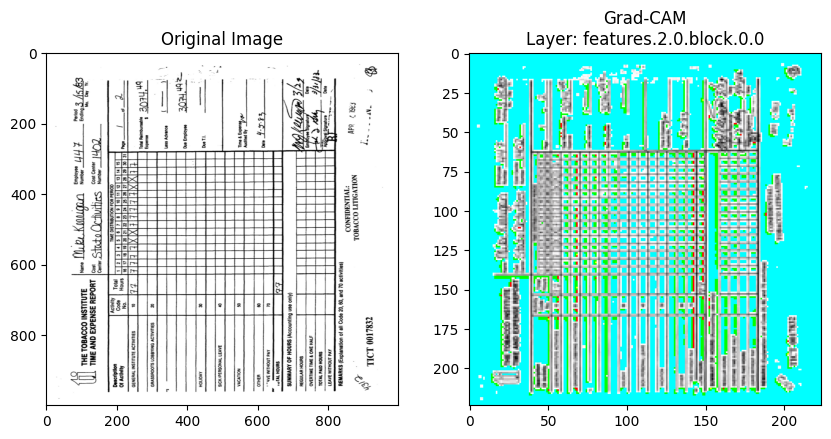

Predicted class: 10
True class: 10


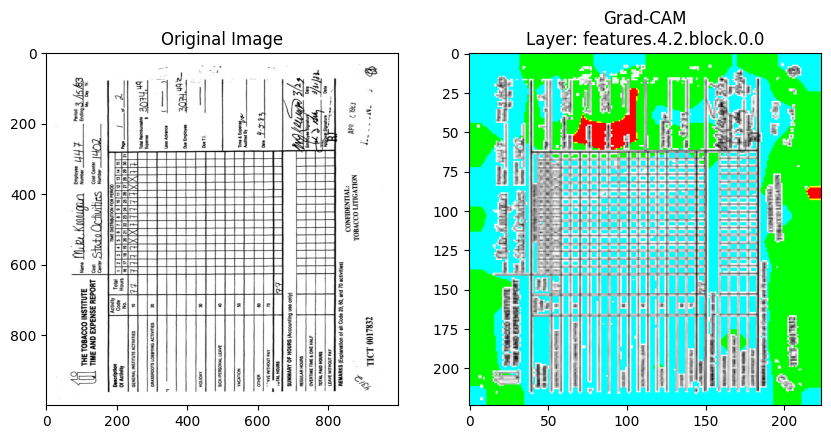

Predicted class: 10
True class: 10


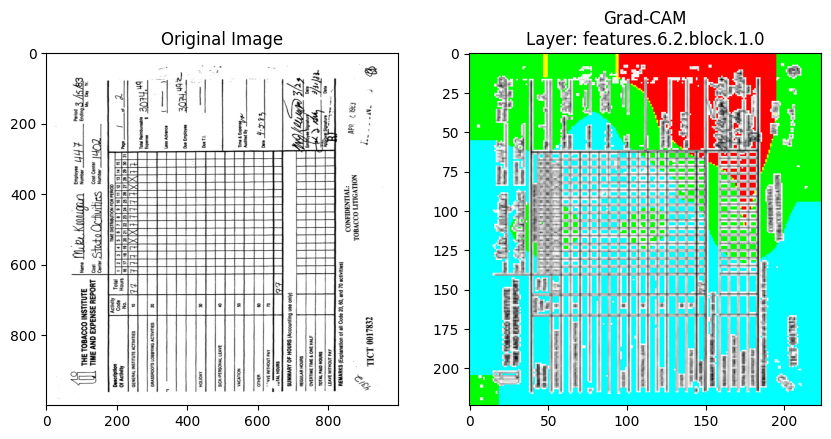

Predicted class: 10
True class: 10


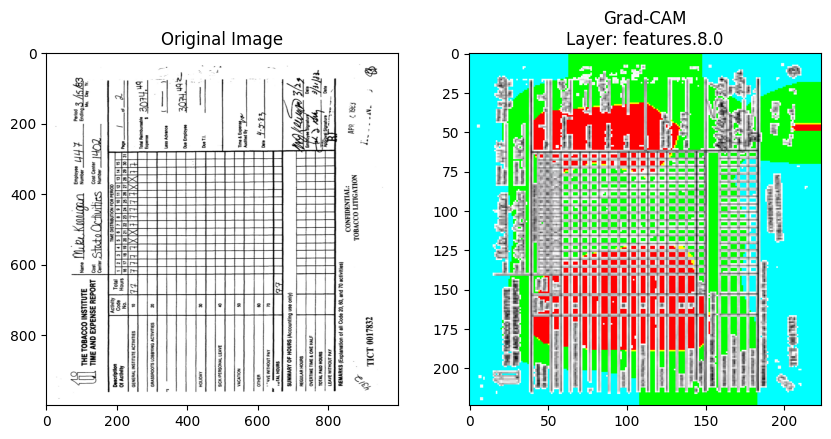

In [12]:
image_dir = 'C:/Users/HP/Desktop/Projet/CODE/RVL_dataset/'

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# Get the list of target layers dynamically from the model
target_layers = get_layers(model)

# Create interactive dropdown menus for selecting an image and a target layer
image_dropdown = widgets.Dropdown(
    options=image_files,
    description='Select Image:',
    disabled=False,
)

layer_dropdown = widgets.Dropdown(
    options=target_layers,
    description='Select Layer:',
    disabled=False,
)

def on_change(change):
    random_image_file = image_dropdown.value
    random_image_path = os.path.join(image_dir, random_image_file)
    image_label = df.loc[df['Image'] == random_image_file, 'Label'].values[0]
    target_layer_name = layer_dropdown.value

    # Load and preprocess the image
    image_tensor = preprocess_image(random_image_path)
    
    # Apply Grad-CAM
    gradients, activations, pred_class = grad_cam(model, image_tensor, target_layer_name)

    # Generate and superimpose heatmap
    heatmap = generate_heatmap(gradients, activations)
    superimposed_img = superimpose_heatmap(image_tensor, heatmap)    
    # Plot the result
    print(f'Predicted class: {pred_class}')
    print(f'True class: {image_label}')
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(random_image_path))
    plt.title(f'Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.title(f'Grad-CAM\nLayer: {target_layer_name}')

    plt.show()
    

image_dropdown.observe(on_change, names='value')
layer_dropdown.observe(on_change, names='value')

# Display the dropdown menus
display(image_dropdown, layer_dropdown)